# Importing Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Loading Datasets

In [2]:
train_data = pd.read_csv('/content/train_data_v3.csv')
test_data = pd.read_csv('/content/test_data_v3.csv')
validate_data = pd.read_csv('/content/validate_data_v3.csv')

train_data.info()
test_data.info()
validate_data.info()

train_data.head()
test_data.head()
validate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 70 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   End_Time                                          8000 non-null   int64  
 1   Distance(mi)                                      8000 non-null   float64
 2   Temperature(F)                                    8000 non-null   float64
 3   Humidity(%)                                       8000 non-null   float64
 4   Pressure(in)                                      8000 non-null   float64
 5   Visibility(mi)                                    8000 non-null   float64
 6   Wind_Speed(mph)                                   8000 non-null   float64
 7   Precipitation(in)                                 8000 non-null   float64
 8   Amenity                                           8000 non-null   int64  
 9   Bump               

,End_Time,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,Wind_Direction_WSW,Wind_Direction_West,Weather_Day_of_Week_Friday,Weather_Day_of_Week_Monday,Weather_Day_of_Week_Saturday,Weather_Day_of_Week_Sunday,Weather_Day_of_Week_Thursday,Weather_Day_of_Week_Tuesday,Weather_Day_of_Week_Wednesday,Severity
0,1376,0.013,46.0,83.0,29.02,10.0,0.0,0.00,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1152,0.086,79.0,62.0,30.05,10.0,9.0,0.00,0,0,...,0,0,0,1,0,0,0,0,0,2
2,928,0.700,60.0,55.0,29.80,10.0,13.0,0.00,0,0,...,0,0,0,0,0,0,0,1,0,3
3,327,0.000,18.0,84.0,31.08,1.2,10.4,0.01,0,0,...,0,0,0,0,0,0,0,0,1,3
4,656,0.386,72.0,69.0,25.02,10.0,0.0,0.00,0,0,...,0,0,0,0,1,0,0,0,0,2


# Building Model

## Separate Target and Features

In [3]:
X_train = train_data.drop(columns=['Severity'])
y_train = train_data['Severity']
X_test = test_data.drop(columns=['Severity'])
y_test = test_data['Severity']
X_validate = validate_data.drop(columns=['Severity'])
y_validate = validate_data['Severity']

## Scale Data

In [4]:
# Scale the data before feature selection and model training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

##Base Model: Linear SVM

In [5]:
param_grid = {
    'C': [0.1, 1, 5],  # Try different values of C
    'kernel': ['linear']  # Force it to only use linear kernel
}

In [6]:
grid_search = GridSearchCV(
    SVC(),                # Base model
    param_grid,           # Hyperparameter grid
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Optimize for accuracy
    n_jobs=-1             # Use all cores
)

In [7]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5], 'kernel': ['linear']},
             scoring='accuracy')

In [8]:
# Evaluate the best model on the test set
best_linear_svm = grid_search.best_estimator_
y_validate_pred_balanced = best_linear_svm.predict(X_validate_scaled)
test_accuracy_balanced = accuracy_score(y_validate, y_validate_pred_balanced)
test_report_balanced = classification_report(y_validate, y_validate_pred_balanced)

# Print results
print("Best Linear SVM Model:", grid_search.best_params_)
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Best Linear SVM Model: {'C': 5, 'kernel': 'linear'}
Test Accuracy After Balancing: 0.337
Classification Report:
               precision    recall  f1-score   support

           1       0.05      0.79      0.10        14
           2       0.93      0.29      0.44       828
           3       0.28      0.60      0.38       124
           4       0.06      0.44      0.10        34

    accuracy                           0.34      1000
   macro avg       0.33      0.53      0.25      1000
weighted avg       0.81      0.34      0.41      1000



<Figure size 1000x800 with 0 Axes>

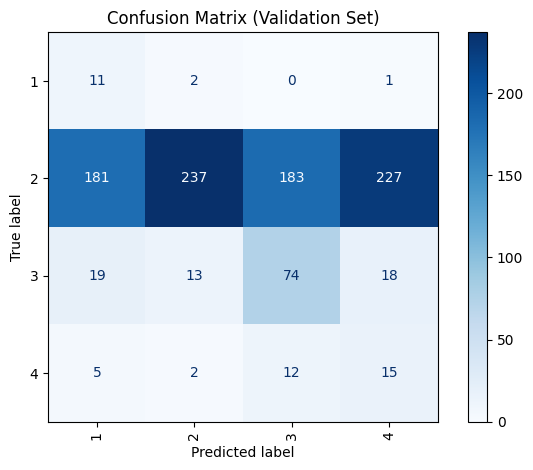

[[ 11   2   0   1]
 [181 237 183 227]
 [ 19  13  74  18]
 [  5   2  12  15]]
acc1 (Exact match accuracy): 0.3370
acc2 (One-off accuracy): 0.7460


In [11]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(best_linear_svm, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=best_linear_svm.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = best_linear_svm.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

##SVM 2nd Model (kernel=rbf)

In [13]:
svm_rbf = Pipeline([
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, C=5))
])
svm_rbf.fit(X_train_scaled, y_train)

Pipeline(steps=[('svm', SVC(C=5, class_weight='balanced', probability=True))])

In [14]:
# Predict on validation set (for hyperparameter tuning)
y_validate_pred = svm_rbf.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = svm_rbf.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Validation Accuracy  0.409
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.06      0.79      0.12        14
           2       0.92      0.37      0.53       828
           3       0.29      0.61      0.39       124
           4       0.06      0.41      0.11        34

    accuracy                           0.41      1000
   macro avg       0.33      0.55      0.29      1000
weighted avg       0.80      0.41      0.49      1000

Test Accuracy After Balancing: 0.398
Classification Report:
               precision    recall  f1-score   support

           1       0.04      1.00      0.07         6
           2       0.91      0.38      0.53       857
           3       0.25      0.52      0.34       119
           4       0.03      0.39      0.06        18

    accuracy                           0.40      1000
   macro avg       0.31      0.57      0.25      1000
weighted avg       0.81      0.40      0.50      1000



<Figure size 1000x800 with 0 Axes>

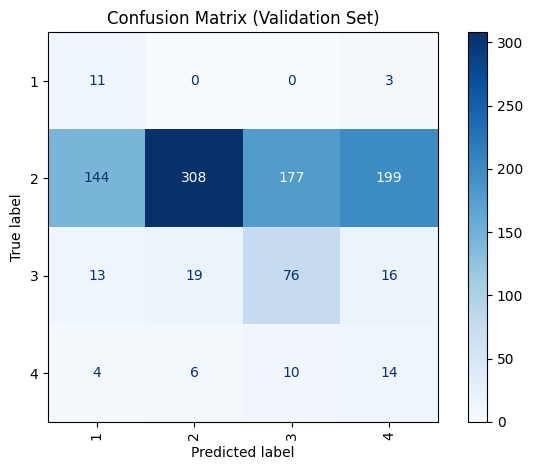

[[ 11   0   0   3]
 [144 308 177 199]
 [ 13  19  76  16]
 [  4   6  10  14]]
acc1 (Exact match accuracy): 0.4090
acc2 (One-off accuracy): 0.7750


In [15]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(svm_rbf, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=svm_rbf.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = svm_rbf.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

## SVM 3rd Model (kernel = poly)

In [16]:
svm_poly = Pipeline([
    ('svm', SVC(kernel='poly', class_weight='balanced', probability=True, C=5))
])
svm_poly.fit(X_train_scaled, y_train)

Pipeline(steps=[('svm',
                 SVC(C=5, class_weight='balanced', kernel='poly',
                     probability=True))])

In [17]:
# Predict on validation set (for hyperparameter tuning)
y_validate_pred = svm_poly.predict(X_validate_scaled)

# Evaluate performance on validation set
validate_accuracy = accuracy_score(y_validate, y_validate_pred)
validate_report = classification_report(y_validate, y_validate_pred)

# Print results on validation set
print("Validation Accuracy ", validate_accuracy)
print("Classification Report (Validation Set):\n", validate_report)

# Evaluate the best model on the test set
y_test_pred_balanced = svm_poly.predict(X_test_scaled)
test_accuracy_balanced = accuracy_score(y_test, y_test_pred_balanced)
test_report_balanced = classification_report(y_test, y_test_pred_balanced)

# Print results
print("Test Accuracy After Balancing:", test_accuracy_balanced)
print("Classification Report:\n", test_report_balanced)

Validation Accuracy  0.368
Classification Report (Validation Set):
               precision    recall  f1-score   support

           1       0.06      0.79      0.11        14
           2       0.91      0.33      0.49       828
           3       0.28      0.53      0.36       124
           4       0.05      0.41      0.09        34

    accuracy                           0.37      1000
   macro avg       0.32      0.52      0.26      1000
weighted avg       0.79      0.37      0.45      1000

Test Accuracy After Balancing: 0.371
Classification Report:
               precision    recall  f1-score   support

           1       0.03      0.83      0.05         6
           2       0.92      0.35      0.51       857
           3       0.25      0.46      0.33       119
           4       0.03      0.39      0.05        18

    accuracy                           0.37      1000
   macro avg       0.31      0.51      0.23      1000
weighted avg       0.82      0.37      0.48      1000



<Figure size 1000x800 with 0 Axes>

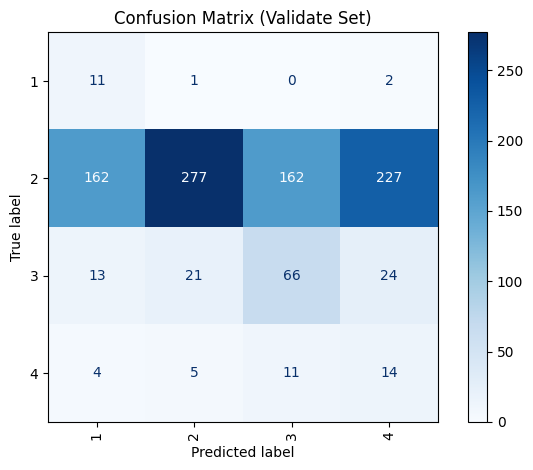

[[ 11   1   0   2]
 [162 277 162 227]
 [ 13  21  66  24]
 [  4   5  11  14]]
acc1 (Exact match accuracy): 0.3680
acc2 (One-off accuracy): 0.7490


In [18]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(svm_poly, X_validate_scaled, y_validate,
                                      cmap='Blues',
                                      display_labels=svm_poly.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validate Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = svm_poly.predict(X_validate_scaled)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")

## Linear SVM with RFE (Recursive feature elimination)

In [19]:
# SVM with RFE (Recursive Feature Elimination)
linear_svm = LinearSVC(C=5, max_iter=5000, class_weight='balanced')
rfe = RFE(estimator=linear_svm, n_features_to_select=20, step=1)  # Keep top 20 features
rfe.fit(X_train_scaled, y_train)

# Get the ranking of features and selected features
selected_features = rfe.support_
X_train_rfe = X_train_scaled[:, selected_features]
X_validate_rfe = X_validate_scaled[:, selected_features]
X_test_rfe = X_test_scaled[:, selected_features]

# Train SVM on selected features
svm_rfe = SVC(kernel='rbf', C=5, gamma=0.1, class_weight='balanced', probability = True)
svm_rfe.fit(X_train_rfe, y_train)

# Predict on validation set (for hyperparameter tuning)
y_validate_pred_rfe = svm_rfe.predict(X_validate_rfe)

# Evaluate performance on validation set
validate_accuracy_rfe = accuracy_score(y_validate, y_validate_pred_rfe)
validate_report_rfe = classification_report(y_validate, y_validate_pred_rfe)

# Print RFE results on validation set
print("Validation Accuracy After RFE:", validate_accuracy_rfe)
print("Classification Report After RFE (Validation Set):\n", validate_report_rfe)

# Evaluate the final model on the test set
y_test_pred_rfe = svm_rfe.predict(X_test_rfe)

# Evaluate performance on the test set
accuracy_rfe = accuracy_score(y_test, y_test_pred_rfe)
report_rfe = classification_report(y_test, y_test_pred_rfe)

# Print final results
print("Test Accuracy After RFE and Hyperparameter Tuning:", accuracy_rfe)
print("Classification Report After RFE (Test Set):\n", report_rfe)

Validation Accuracy After RFE: 0.417
Classification Report After RFE (Validation Set):
               precision    recall  f1-score   support

           1       0.09      0.93      0.16        14
           2       0.93      0.36      0.52       828
           3       0.28      0.69      0.40       124
           4       0.08      0.53      0.14        34

    accuracy                           0.42      1000
   macro avg       0.34      0.63      0.31      1000
weighted avg       0.81      0.42      0.49      1000

Test Accuracy After RFE and Hyperparameter Tuning: 0.418
Classification Report After RFE (Test Set):
               precision    recall  f1-score   support

           1       0.04      1.00      0.08         6
           2       0.94      0.39      0.55       857
           3       0.26      0.61      0.36       119
           4       0.03      0.44      0.06        18

    accuracy                           0.42      1000
   macro avg       0.32      0.61      0.26      

<Figure size 1000x800 with 0 Axes>

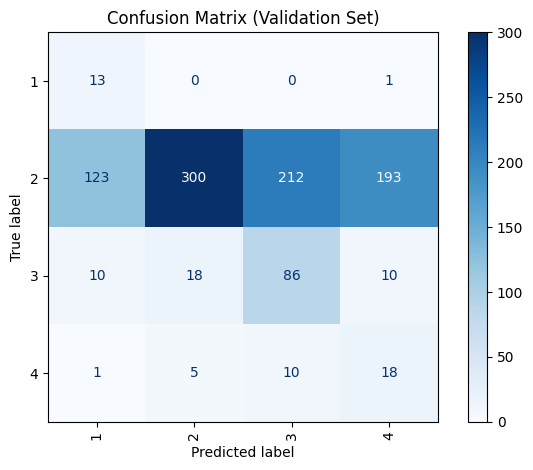

[[ 13   0   0   1]
 [123 300 212 193]
 [ 10  18  86  10]
 [  1   5  10  18]]
acc1 (Exact match accuracy): 0.4170
acc2 (One-off accuracy): 0.7900


In [20]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(svm_rfe, X_validate_rfe, y_validate,
                                      cmap='Blues',
                                      display_labels=svm_rfe.classes_,
                                      xticks_rotation='vertical')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix

# Get the predictions
y_pred = svm_rfe.predict(X_validate_rfe)

# Get the confusion matrix
cm = confusion_matrix(y_validate, y_pred)
print(cm)

# acc1 = correct predictions / total samples
acc1 = np.trace(cm) / np.sum(cm)
print(f"acc1 (Exact match accuracy): {acc1:.4f}")

# Initialize
correct_or_one_off = 0

# Loop through the confusion matrix
n_classes = cm.shape[0]

for i in range(n_classes):
    correct_or_one_off += cm[i, i]  # exact
    if i > 0:
        correct_or_one_off += cm[i, i-1]  # one below
    if i < n_classes - 1:
        correct_or_one_off += cm[i, i+1]  # one above

# acc2 = (correct + one-off) / total samples
acc2 = correct_or_one_off / np.sum(cm)
print(f"acc2 (One-off accuracy): {acc2:.4f}")